# Data-analyse Tweede Kamer moties
> Graven in 30.000 moties vanaf 2009

- toc: false
- branch: master
- badges: true
- comments: true
- author: Jesse van Elteren
- image: images/moties.jpg
- categories: []

![](moties/tweede_kamer.png)

De verkiezingen komen er weer aan, en de Tweede Kamer heeft een [open data portaal](https://opendata.tweedekamer.nl/). Daar heb ik eens fijn gebruik van gemaakt en alle moties vanaf 2009 gedownload. Het zijn er om precies te zijn 29514 en in dit blog onderzoeken we of we hier interessante inzichten uit kunnen halen.

In [36]:
# hide
import pickle
import datetime
from collections import namedtuple, Counter
import numpy as np
import pandas as pd
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import altair as alt
import pprint

In [37]:
# hide
file = open("moties_processed_df.pickle","rb")
df = pickle.load(file)
print('aantal moties in dataset:', len(df))

aantal moties in dataset: 29514


In [ ]:
# hide
# https://imagecolorpicker.com/
party_colors = {
'CDA':'#5cb957',
 'ChristenUnie':'#00a5e8',
 'D66':'#04a438',
 'GroenLinks':'#48a641',
 'PVV':'#002759',
 'PvdA':'#df111a',
 'PvdD':'#006b2d',
 'SGP':'#d86120',
 'SP':'#e3001b',
 'VVD':'#ff7f0e',
 'DENK':'#17becf',
 'FVD':'#800000',
 'Groep Krol/vKA':'pink'}

column_list = df.columns.values
indiener_column = [c for c in column_list if ('Indiener') in c and c != 'Indiener_persoon']
medeindiener_column = [c for c in column_list if 'Medeindiener' in c and c != 'Medeindiener_persoon']
stem_column = [c for c in column_list if 'Stem_' in c and c != 'Stem_persoon']
aantal_stemmen_column = [c for c in column_list if 'Aantal' in c]


In [75]:
# hide
# make a column with the indienende partij
ind = pd.melt(df, value_vars=indiener_column, ignore_index=False)
ind = ind[ind['value'] == 1]
ind = ind.rename(columns={'variable':'Indienende_partij'})
ind['Indienende_partij'] = ind['Indienende_partij'].str[9:]
df['Indiener_persoon'] = df['Indiener_persoon'].map(lambda x: x[0] if x else '')
df = df.join(ind['Indienende_partij'], how='left')
df['Indienende_persoon_partij'] = df['Indiener_persoon'] + ', ' + df['Indienende_partij']

In [ ]:
# hide
def get_largest_parties(year=2020,top=False):
    tmp = df[(df['Vergaderjaar']==str(year)+'-'+str(year+1))]
    parties = [p for p in tmp.columns if 'Aantal_stemmen' in p][1:]
    tmp = tmp[parties].mean().sort_values(ascending=False)
    tmp = tmp[tmp.notna()]
    tmp.index = tmp.index.str[15:]
    if top: return tmp[:top].index
    else: return tmp.index

def get_largest_parties_chamber(chamber='Rutte III',top=False):
    tmp = df[df['Kamer']== chamber]
    parties = [p for p in tmp.columns if 'Aantal_stemmen' in p][1:]
    tmp = tmp[parties].mean().sort_values(ascending=False)
    tmp = tmp[tmp.notna()]
    tmp.index = tmp.index.str[15:]
    if top: return tmp[:top].index
    else: return tmp.index

def to_vergaderjaar(year):
    return str(year) + '-' + str(year+1)

def get_stem_column(largest):
    return [c for c in column_list if 'Stem_' in c and c != 'Stem_persoon' and c[5:] in largest]
  
get_largest_parties(2020)

In [ ]:
# hide
get_largest_parties_chamber("Rutte III", 13)

In [42]:
# hide
Cabinet = namedtuple('Cabinet', ['name','start', 'end', 'demissionair','coalition'])
Chamber = namedtuple('Chamber', ['name','start', 'end', 'numyears'])

chamber_input = [
    "Balkenende IV,01 01 2009,16 06 2010",# mark begin 2008 is not correct (should be 30 11 2006) but for dataset purpose it it
    "Rutte I,17 06 2010,19 09 2012",
    "Rutte II,20 09 2012,22 03 2017",
    "Rutte III,23 03 2017,31 12 2020"] # mark end 2020 is not correct but for dataset purpose it it

chambers = {}
for c in chamber_input:
    c = c.split(',')
    name = c[0]
    start = list(map(int, c[1].split()))
    startdate = datetime.datetime(start[2], start[1], start[0])
    end = list(map(int, c[2].split()))
    enddate = datetime.datetime(end[2], end[1], end[0])
    numyears = (enddate - startdate).days/365
    chambers[name] = Chamber(name, startdate, enddate, numyears)


cabinets_input = [
    # "Balkenende III,07 07 2006,22 02 2007,CDA VVD",
    # "Balkenende IV,22 02 2007,14 10 2010,CDA PvdA ChristenUnie",
    "Balkenende IV,18 09 2008,14 10 2010,20 02 2010,CDA PvdA ChristenUnie",
    "Rutte I,14 10 2010,5 11 2012,23 04 2012,VVD CDA PVV",
    "Rutte II,5 11 2012,26 10 2017,14 03 2017,VVD PvdA",
    "Rutte III,26 10 2017,15 01 2022,15 01 2022,CDA VVD D66 ChristenUnie"]

cabinets = {}
for c in cabinets_input:
    c = c.split(',')
    name = c[0]
    start = list(map(int, c[1].split()))
    startdate = datetime.datetime(start[2], start[1], start[0])
    end = list(map(int, c[2].split()))
    enddate = datetime.datetime(end[2], end[1], end[0])
    coalition = tuple(c[3].split())
    cabinets[name] = Cabinet(name, startdate, enddate, numyears, coalition)
cabinets, chambers

({'Balkenende IV': Cabinet(name='Balkenende IV', start=datetime.datetime(2008, 9, 18, 0, 0), end=datetime.datetime(2010, 10, 14, 0, 0), demissionair=3.778082191780822, coalition=('20', '02', '2010')),
  'Rutte I': Cabinet(name='Rutte I', start=datetime.datetime(2010, 10, 14, 0, 0), end=datetime.datetime(2012, 11, 5, 0, 0), demissionair=3.778082191780822, coalition=('23', '04', '2012')),
  'Rutte II': Cabinet(name='Rutte II', start=datetime.datetime(2012, 11, 5, 0, 0), end=datetime.datetime(2017, 10, 26, 0, 0), demissionair=3.778082191780822, coalition=('14', '03', '2017')),
  'Rutte III': Cabinet(name='Rutte III', start=datetime.datetime(2017, 10, 26, 0, 0), end=datetime.datetime(2022, 1, 15, 0, 0), demissionair=3.778082191780822, coalition=('15', '01', '2022'))},
 {'Balkenende IV': Chamber(name='Balkenende IV', start=datetime.datetime(2009, 1, 1, 0, 0), end=datetime.datetime(2010, 6, 16, 0, 0), numyears=1.4547945205479451),
  'Rutte I': Chamber(name='Rutte I', start=datetime.datetime(

In [113]:
# hide
def get_pca(df, n_components=1, chamber='Rutte III', num_largest=None, return_ratio=False):
    largest = get_largest_parties_chamber(chamber, num_largest)
    stem_column = get_stem_column(largest)
    source_year = df.loc[df['Kamer'] == chamber][stem_column].dropna(axis=1, how='all').T
    X_year = SimpleImputer(strategy='most_frequent').fit_transform(source_year)
    pca = PCA(n_components = n_components)
    pca = pca.fit(X_year)
    print('PCA results for',chamber)
    print('explained variance by factors', pca.explained_variance_ratio_,pca.explained_variance_ratio_.sum())  
    res_year = pca.transform(X_year)
    source = pd.DataFrame(res_year)
    source['partij'] = source_year.T.columns.str[5:]
    source = source.rename(index=str, columns={0: "x", 1: "y"}).sort_values('x',ascending=False)
    return (source, pca.explained_variance_ratio_) if return_ratio else source

chamber = 'Rutte III'
source = get_pca(df, n_components = 1, chamber = chamber, num_largest = 13)
# this variable will be used throughout the notebook!
parties = source['partij'][::-1]
parties = [p for p in parties if p in get_largest_parties(2020,12)]

PCA results for Rutte III
explained variance by factors [0.3876739] 0.38767389654752415


## Ontwikkeling van het aantal moties

In [44]:
# hide_input
data = df.groupby(['Jaar', 'BesluitSoort']).agg(Aantal=('Titel', 'count')).reset_index()
data = data.replace({0: 'Afgewezen', 1: 'Aangenomen'})
color_order = {'Afgewezen':1, 'Aangenomen':0}
data["idx"] = data["BesluitSoort"].map(color_order)

alt.Chart(data, width=400,height = 150).mark_bar().encode(
    x=alt.X('Jaar:N'),
    y='Aantal:Q',
    order="idx",
    color=alt.Color('BesluitSoort',
                   scale=alt.Scale(
            domain=['Aangenomen','Afgewezen'],
            range=['green', 'red']))
)

alt.Chart(...)

Het aantal moties stijgt, met name het aantal aangenomen moties. In verkiezingsjaren (2010, 2012 en 2017) ligt het aantal moties duidelijk lager. Tussen 2012 en 2013 werden relatief veel moties afgewezen.

In [45]:
# hide_input
data = df.groupby(['Jaar', 'BesluitSoort']).agg(Aantal=('Voor', 'mean')).reset_index()
data = data.replace({0: 'Afgewezen', 1: 'Aangenomen'})

# source = source.melt('index',var_name='Stem', value_name='Gemiddeld aantal voorstemmen')
# source['index'] += 2008
chart = alt.Chart(data,width=400,height = 150).mark_line().encode(
    x=alt.X('Jaar:N', axis=alt.Axis(title='Jaar')),
    y='Aantal:Q',
    color=alt.Color('BesluitSoort:N',
                scale=alt.Scale(
        domain=['Aangenomen','Afgewezen'],
        range=['green', 'red']))

)
chart.encoding.y.title = 'Aantal voorstemmen'
chart

alt.Chart(...)

Moties die worden aangenomen halen meestal rond de 120 voorstemmen. Moties die het niet halen blijven meestal rond de 50 stemmen hangen. Eigenlijk zegt zo'n gemiddelde niet zoveel en kan je beter naar de verdeling van het aantal voorstemmen kijken, dat doen we nu met een histogram per kabinetsperiode.

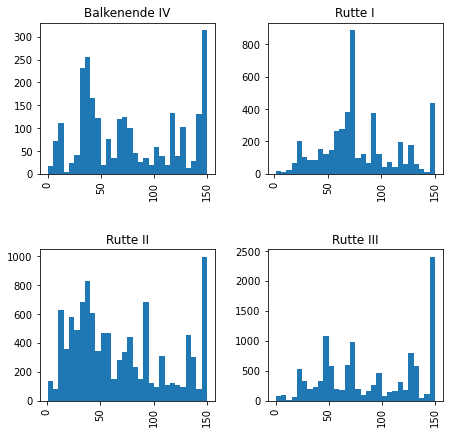

In [115]:
# hide_input
df['Voor'].hist(by=df['Kamer'], bins=30, figsize=(7,7));

In bovenstaande histogrammen gaat het vooral om de verdeling van de moties tijdens de kamerperiodes. Het absolute aantal is niet echt vergelijkbaar omdat de duur van de kabinetten verschillend is. 
* Balkenende IV: een piek van ongeveer 200 moties die nauwelijks stemmen krijgen (waarschijnlijk soort protestmoties), een grote piek met moties die rond de 35 stemmen blijven hangen en een piek met unaniem aangenomen moties
* Rutte I: relatief meer moties die het nipt wel of juist niet haalden.
* Rutte II: verlijkbaar met Balkenende IV, behalve dat de meeste moties onder de 75 bleven steken
* Rutte III: hele grote piek in het aantal unaniem aangenomen moties. Dit lijken er ook steeds meer te worden (500 in 2018, 700 in 2019 en 900 in 2020)

In [47]:
# hide_input
medeindieners = df['Medeindiener_persoon'].values
c = Counter(len(i) for i in medeindieners)
c.most_common()
source = pd.DataFrame(c.most_common()).rename(columns={0:'Aantal medeindieners',1:'Aantal moties'})
alt.Chart(source,width=400,height = 150).mark_bar().encode(
    x=alt.X('Aantal medeindieners:O',sort=alt.EncodingSortField(field="x", op="count", order='ascending')),
    y='Aantal moties:Q'
)

alt.Chart(...)

Meestal worden moties ingediend door 1 partij, maar soms zijn er medeindieners. Sinds 2008 is er [één special snowflake motie](https://www.tweedekamer.nl/kamerstukken/detail?id=2020Z20755&did=2020D44509), met maar liefst 16 medeindieners. Van harte Dion Graus met dit wapenfeit!

# hide
## Komt elke partij opdagen?

In [48]:
# hide
# how many percent of moties did parties vote. Conclusion almost all
nan_per_party = df[stem_column].isnull().groupby([df['Kamer']]).sum()
count_per_chamber = df.groupby(['Kamer']).count()['Titel']
relevant_parties = ['Stem_'+p for p in get_largest_parties(2020)]
1- np.divide(nan_per_party, count_per_chamber.values[:,None])[relevant_parties]

,Stem_VVD,Stem_PVV,Stem_CDA,Stem_D66,Stem_GroenLinks,Stem_SP,Stem_PvdA,Stem_ChristenUnie,Stem_PvdD,Stem_DENK,Stem_SGP,Stem_FVD,Stem_Krol,Stem_Van Haga,Stem_Van Kooten-Arissen
Kamer,,,,,,,,,,,,,,,
Balkenende IV,1.000000,0.985759,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999604,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000
Rutte I,0.999790,1.000000,1.000000,1.000000,0.999790,1.000000,0.999790,1.000000,1.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000
Rutte II,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000
Rutte III,0.999041,0.999041,0.999041,0.999041,0.999041,0.999041,0.999041,0.999041,0.998954,0.99756,0.999041,0.978824,0.147625,0.354771,0.340741


In [49]:
# hide
relevant_parties = ['Aantal_stemmen_'+p for p in get_largest_parties(2020)]
mean_votes_per_party = df.replace(np.nan, 0).groupby('Kamer').mean()[relevant_parties]
max_votes_per_party = df[(relevant_parties+['Kamer'])].groupby('Kamer').quantile(.95)
np.divide(mean_votes_per_party, max_votes_per_party.values)

,Aantal_stemmen_VVD,Aantal_stemmen_PVV,Aantal_stemmen_CDA,Aantal_stemmen_D66,Aantal_stemmen_GroenLinks,Aantal_stemmen_SP,Aantal_stemmen_PvdA,Aantal_stemmen_ChristenUnie,Aantal_stemmen_PvdD,Aantal_stemmen_DENK,Aantal_stemmen_SGP,Aantal_stemmen_FVD,Aantal_stemmen_Krol,Aantal_stemmen_Van Haga,Aantal_stemmen_Van Kooten-Arissen
Kamer,,,,,,,,,,,,,,,
Balkenende IV,0.998700,0.987342,0.999344,1.003033,1.000170,0.999525,0.999988,0.999802,0.999604,NaN,1.000198,NaN,NaN,NaN,NaN
Rutte I,0.999993,0.987544,0.999760,1.000126,0.999412,1.000000,0.999958,1.000000,1.000000,NaN,1.000315,NaN,NaN,NaN,NaN
Rutte II,0.986980,0.854401,1.000000,0.999876,0.999605,1.000000,0.966950,1.000000,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN
Rutte III,0.986202,0.997050,0.999041,0.999041,0.999041,0.999041,0.999041,0.999041,0.912157,0.99756,0.999041,0.978824,0.147625,0.354771,0.340741


In [50]:
# hide
# there is something where a motion has been voted upon later, e.g. below motion is in Balkenende IV, but PVV only got to 24 chairs in Rutte I
df[(df['Kamer']=='Balkenende IV') & (df['Aantal_stemmen_PVV']==24)]

,Titel,AgendapuntOnderwerp,Onderwerp,Datum,GestartOp,Vergaderjaar,Jaar,Kamer,Kabinet,Demissionair,...,Stem_PvdA,Stem_PvdD,Stem_SGP,Stem_SP,Stem_VVD,Stem_Van Haga,Stem_Van Klaveren,Stem_Van Kooten-Arissen,Stem_Van Vliet,Stem_Verdonk
2010Z06296,Prenatale screening,Stemming over: aangehouden motie ingediend bij...,Motie-Langkamp/Arib over een EHBO-certificaat ...,2010-04-08,2010-04-08,2009-2010,2010,Balkenende IV,Balkenende IV,True,...,1.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
2010Z06641,Voorstel van wet van de leden Koser Kaya en Bl...,Stemming over: motie ingediend bij Voorstel va...,Motie Omtzigt c.s. over modernisering van de g...,2010-04-13,2010-04-13,2009-2010,2010,Balkenende IV,Balkenende IV,True,...,1.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN


# hide
## Welke partij is de 'tegenpartij'?

In [51]:
# hide
startjaar = 2020
data = df.groupby(['Kamer']).mean()[['Stem_'+p for p in get_largest_parties(startjaar,12)]]
data = data.reset_index()
data = data.melt('Kamer',var_name='Stem', value_name='Stemgedrag')

alt.Chart(data,width=600).mark_line().encode(
    x='Kamer:N',
    y=alt.Y('Stemgedrag:Q'),
    color='Stem:N',
)

alt.Chart(...)

# hide
VVD stemt het meeste tegen. Waarschijnlijk omdat de meeste moties gericht zijn aan de regering en de VVD eigenlijk altijd regeert

## Welke partijen dienen het meeste moties in en hoe succesvol zijn ze?

In [76]:
# hide
def get_summary_stats(df):
    df = df.dropna(axis='columns',how='all')
    indiener_column = [c for c in df.columns if 'Indiener' in c]
    indiener = {p:p[9:] for p in indiener_column}
    df = df.rename(indiener,axis=1)
    largest_parties = get_largest_parties(2020,12)
    indiener_column = [i for i in indiener.values() if i in largest_parties]
    aantal_stemmen_column = [c for c in df.columns if 'Aantal_stemmen' in c]
      
    success_rate = np.multiply(df[indiener_column],df['BesluitSoort'][:, np.newaxis]).mean(axis=0).sort_index()
    success_rate = success_rate[success_rate.notna()]
    aantal_moties = df[indiener_column].sum().sort_index()
    aantal_moties = aantal_moties[aantal_moties.notna()]
    aantal_succesvolle_moties = np.multiply(success_rate,aantal_moties)
    aantal_succesvolle_moties = aantal_succesvolle_moties[aantal_succesvolle_moties.notna()]
    aantal_niet_succesvolle_moties = np.multiply((1-success_rate),aantal_moties)
    aantal_niet_succesvolle_moties = aantal_niet_succesvolle_moties[aantal_niet_succesvolle_moties.notna()]
    aantal_zetels = df[aantal_stemmen_column].mean()
    aantal_zetels = aantal_zetels[['Aantal_stemmen_'+p for p in aantal_moties.index]]
    aantal_zetels.index = aantal_moties.index
    aantal_zetels = aantal_zetels[aantal_zetels.notna()]
    aantal_zetels.index = aantal_moties.index
    aantal_moties_zetel = np.divide(aantal_moties,aantal_zetels)
    aantal_succesvolle_moties_zetel = np.divide(aantal_succesvolle_moties,aantal_zetels)
    aantal_niet_succesvolle_moties_zetel = np.divide((aantal_moties-aantal_succesvolle_moties),aantal_zetels)
    return success_rate,aantal_moties,aantal_succesvolle_moties,aantal_niet_succesvolle_moties, aantal_zetels, aantal_moties_zetel,aantal_succesvolle_moties_zetel,aantal_niet_succesvolle_moties_zetel

party_perf = pd.DataFrame({})
res_columns = ['success_rate','aantal_moties','aantal_succesvolle_moties','aantal_niet_succesvolle_moties', 'aantal_zetels', 'aantal_moties_zetel','aantal_succesvolle_moties_zetel','aantal_niet_succesvolle_moties_zetel']
for k in df['Kamer'].unique():
    result = get_summary_stats(df.loc[df['Kamer'] == k])
    for i,res in enumerate(result):
        df_temp = pd.DataFrame(res).reset_index()
        df_temp['stat']=res_columns[i]
        df_temp['kamer']= k
        party_perf = party_perf.append(df_temp, ignore_index = True)
# for start_year in range(year,2020):
#     result = get_summary_stats(start_year,df.loc[df['Vergaderjaar'] == str(start_year)+'-'+str(start_year+1)])
#     for i,res in enumerate(result):
#         df_temp = pd.DataFrame(res).reset_index()
#         df_temp['stat']=res_columns[i]
#         df_temp['year']=str(start_year)+'-'+str(start_year+1)
#         party_perf = party_perf.append(df_temp, ignore_index = True)
party_perf = party_perf.rename({'index':'partij',0:'value'},axis=1)

In [77]:
# hide
# normalize metrics starting with 'aantal' to account for length of ca
mask = party_perf['stat'].str.contains('aantal')
valid = party_perf[mask]
party_perf.loc[mask, 'value'] = valid['value'] / valid['kamer'].map(lambda x: chambers[x].numyears)

In [114]:
# hide_input
# Step 1: create the line
metric_of_interest = 'aantal_succesvolle_moties_zetel'
data = party_perf[party_perf['stat'] == metric_of_interest]
data['partij'] = pd.Categorical(data['partij'], parties)
data = data.sort_values("partij")

area = alt.Chart(data
    #maybe dont do joinaggreage
    ).transform_calculate(
    order="{'PvdD': 11,'SP': 10, 'GroenLinks': 9, 'DENK': 8, 'PvdA': 7, 'PVV': 6,'FVD': 5, 'SGP': 4, 'D66': 3, 'ChristenUnie': 2, 'CDA': 1, 'VVD': 0, 'Groep Krol/vKA':5.5}[datum.partij]"  
    ).mark_area(interpolate="monotone").encode(
    x='kamer:O',
    y=alt.Y("value:Q", stack='zero'),
    order='order:O',
    color=alt.Color("partij", scale = alt.Scale(domain=parties,range= [party_colors[p] for p in parties])))
    # # color=alt.Color('partij:N', scale=alt.Scale(
    #         domain=parties,
    #         range= [party_colors[p] for p in parties]), sort=alt.SortField("order:O", "descending"))).transform_filter(alt.FieldEqualPredicate(field='stat', equal=metric_of_interest))
area.encoding.y.title = metric_of_interest


def get_y_positions(data, kamer):
    return data.groupby(["kamer", "partij"]).sum().loc[kamer].iloc[::-1].cumsum()["value"]

def get_bar_width(kamer, partij):
    print(kamer,partij)
    query = f'kamer == "{kamer}" & partij == "{partij}"'
    return data.query(query)['value'].values[0]
    
xpos = ['Rutte III' if i%3==2 or p in ['FVD','DENK','Groep Krol/vKA']
                else 'Rutte II' if i%3==1
                else 'Rutte I' 
                for i, p in enumerate(parties)]

ys = {c: get_y_positions(data, c) for c in chambers}
ypos = [ys[xpos[i]].loc[p] - 0.5* get_bar_width(xpos[i],p) for i, p in enumerate(parties)]
test = [get_bar_width(xpos[i],p) for i, p in enumerate(parties)]
demotext = pd.DataFrame({'kamer': xpos, 'value': ypos, 'partij': parties, 'test':test})
demotext

t = (alt.Chart(demotext).mark_text()
        .encode(
    x='kamer:O',
    y='value:Q',
    text='partij:N'
))

chart = alt.layer(area, t, width=600)
chart

Rutte I VVD
Rutte II CDA
Rutte III ChristenUnie
Rutte I D66
Rutte II SGP
Rutte III FVD
Rutte I PVV
Rutte II PvdA
Rutte III DENK
Rutte I GroenLinks
Rutte II SP
Rutte III PvdD
Rutte I VVD
Rutte II CDA
Rutte III ChristenUnie
Rutte I D66
Rutte II SGP
Rutte III FVD
Rutte I PVV
Rutte II PvdA
Rutte III DENK
Rutte I GroenLinks
Rutte II SP
Rutte III PvdD


alt.LayerChart(...)

Opvallend dat de VVD eigenlijk al jaren lang weinig succesvolle moties indient, terwijl andere regeringspartijen dit wel doen. Dit komt natuurlijk ook doordat ze in de regering zitten en op die manier invloed uitoefenen.

In [116]:
# hide_input
party_perf = party_perf.loc[party_perf['partij'].isin(get_largest_parties(2020))]
chart = alt.Chart(party_perf).mark_bar().encode(
    column='kamer',
    x='value:Q',
    y='partij',
    color=alt.Color('stat',
                scale=alt.Scale(
        domain=['aantal_succesvolle_moties','aantal_niet_succesvolle_moties'],
        range=['green', 'red']))
).properties(width=100).transform_filter(alt.FieldOneOfPredicate(field='stat', oneOf=['aantal_succesvolle_moties','aantal_niet_succesvolle_moties']))
chart.encoding.x.title = 'Aantal moties'
chart

alt.Chart(...)

Deze visualisatie geeft weer hoe succesvol partijen zijn geweest tijdens de verschillende kamerperiodes. Je ziet bijvoorbeeld de PVV, PvdD en SP als partijen met veel moties, maar weinig succesvolle. Hoewel de sommige partijen hiervan goede ideeen hebben, zijn ze in elk geval niet succesvol in ze door te voeren.

Bij de regeringspartijen is het opvallend hoe succesvol hun moties zijn. Waarschijnlijk omdat ze samen een meerderheid hebben en dus zo hun moties geaccepteerd krijgen.

In [80]:
# hide_input
chart = alt.Chart(party_perf).mark_bar().encode(
    column='kamer',
    x='value:Q',
    y='partij',
    color=alt.Color('stat',
                scale=alt.Scale(
        domain=['aantal_succesvolle_moties_zetel','aantal_niet_succesvolle_moties_zetel'],
        range=['green', 'red']))
).properties(width=100).transform_filter(alt.FieldOneOfPredicate(field='stat', oneOf=['aantal_succesvolle_moties_zetel','aantal_niet_succesvolle_moties_zetel']))
chart.encoding.x.title = 'Aantal moties'
chart

alt.Chart(...)

Wederom valt hier het lage aantal moties op bij VVD per zetel. Het is natuurlijk ook de partij met het hoogste aantal zetels, maar toch. Ook is de 'output' per zetel is vrij stabiel bij de meeste partijen, hoewel een partij die in de regering gaat meteen een stuk minder moties indient (bijvoorbeeld de PvdA)

## Wie zijn de 'motiekanonnen' van de Tweede Kamer?

In [103]:
# hide_input
for chamber in chambers:
    indieners = df[(df['Kamer'] == chamber)]['Indienende_persoon_partij'].values
    c = Counter(indieners)
    print(f'\nMeeste moties, {chamber}')
    pprint.pprint(c.most_common(5))


Meeste moties, Balkenende IV
[('E. Ouwehand, PvdD', 82),
 ('H.P.J. van Gerven, SP', 62),
 ('W. van Gent, GroenLinks', 60),
 ('M.L. Thieme, PvdD', 60),
 ('K. van Velzen, SP', 57)]

Meeste moties, Rutte I
[('E. Ouwehand, PvdD', 188),
 ('H.P.J. van Gerven, SP', 175),
 ('E.E. Wiegman-van Meppelen Scheppink, ChristenUnie', 143),
 ('S. van Veldhoven, D66', 117),
 ('J.S. Voordewind, ChristenUnie', 110)]

Meeste moties, Rutte II
[('R.K. Dik-Faber, ChristenUnie', 364),
 ('L. van Tongeren, GroenLinks', 343),
 ('E. Ouwehand, PvdD', 313),
 ('S. van Veldhoven, D66', 257),
 ('H.P.J. van Gerven, SP', 252)]

Meeste moties, Rutte III
[('L. van Raan, PvdD', 325),
 ('E.M. Westerveld, GroenLinks', 251),
 ('S.M. Beckerman, SP', 243),
 ('F.P. Wassenberg, PvdD', 225),
 ('E. Ouwehand, PvdD', 210)]


In [102]:
# hide_input
for chamber in chambers:
    indieners = df[(df['Kamer'] == chamber) & (df['BesluitSoort'] == 1)]['Indienende_persoon_partij'].values
    c = Counter(indieners)
    print(f'\nMeeste succesvolle moties, {chamber}')
    pprint.pprint(c.most_common(5))


Meeste succesvolle moties, Balkenende IV
[('E.A. Cramer, ChristenUnie', 29),
 ('E.E. Wiegman-van Meppelen Scheppink, ChristenUnie', 27),
 ('B. van der Ham, D66', 25),
 ('J.J. Atsma, CDA', 24),
 ('J.S. Voordewind, ChristenUnie', 23)]

Meeste succesvolle moties, Rutte I
[('S. van Veldhoven, D66', 59),
 ('G.P.J. Koopmans, CDA', 49),
 ('E.E. Wiegman-van Meppelen Scheppink, ChristenUnie', 48),
 ('A. Slob, ChristenUnie', 41),
 ('J.S. Voordewind, ChristenUnie', 40)]

Meeste succesvolle moties, Rutte II
[('R.K. Dik-Faber, ChristenUnie', 170),
 ('S. van Veldhoven, D66', 156),
 ('L. van Tongeren, GroenLinks', 109),
 ('V.A. Bergkamp, D66', 91),
 ('L.G.J. Voortman, GroenLinks', 80)]

Meeste succesvolle moties, Rutte III
[('R.K. Dik-Faber, ChristenUnie', 154),
 ('J.A.M.J. van den Berg, CDA', 119),
 ('E.M. Westerveld, GroenLinks', 114),
 ('J.M. Paternotte, D66', 98),
 ('C.E. Ellemeet, GroenLinks', 94)]


In [84]:
# hide
df[(df['Kamer'] == 'Rutte III') & (df['BesluitSoort'] == 1) & df['Indiener_ChristenUnie']==1]

,Titel,AgendapuntOnderwerp,Onderwerp,Datum,GestartOp,Vergaderjaar,Jaar,Kamer,Kabinet,Demissionair,...,Stem_SGP,Stem_SP,Stem_VVD,Stem_Van Haga,Stem_Van Klaveren,Stem_Van Kooten-Arissen,Stem_Van Vliet,Stem_Verdonk,Indienende_partij,Indienende_persoon_partij
2017Z04433,Beleid ten aanzien van ontwikkelingssamenwerking,Moties ingediend tijdens het debat,Motie van het lid Voordewind c.s. over per dir...,2017-04-04,2017-04-04,2016-2017,2017,Rutte III,Rutte II,True,...,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,ChristenUnie,"J.S. Voordewind, ChristenUnie"
2017Z04546,Toekomst veehouderij,Stemmingen over: moties ingediend bij het dert...,Motie van het lid Dik-Faber over het actief on...,2017-04-05,2017-04-05,2016-2017,2017,Rutte III,Rutte II,True,...,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,ChristenUnie,"R.K. Dik-Faber, ChristenUnie"
2017Z04628,Rassendiscriminatie,Moties ingediend tijdens het debat,Motie van de leden Segers en Van Brenk over st...,2017-04-06,2017-04-06,2016-2017,2017,Rutte III,Rutte II,True,...,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,ChristenUnie,"G.J.M. Segers, ChristenUnie"
2017Z04627,Rassendiscriminatie,Moties ingediend tijdens het debat,Motie van de leden Segers en Van Dam over een ...,2017-04-06,2017-04-06,2016-2017,2017,Rutte III,Rutte II,True,...,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,ChristenUnie,"G.J.M. Segers, ChristenUnie"
2017Z05341,Europese Raad,Moties ingediend bij het debat over de Europes...,Motie van het lid Voordewind over het juridisc...,2017-04-19,2017-04-19,2016-2017,2017,Rutte III,Rutte II,True,...,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,ChristenUnie,"J.S. Voordewind, ChristenUnie"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020Z24948,Openbaar vervoer,Aangehouden motie ingediend bij het notaoverle...,Gewijzigde motie van het lid Van der Graaf c.s...,2020-12-17,2020-12-17,2020-2021,2020,Rutte III,Rutte III,False,...,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,ChristenUnie,"S.J.F. van der Graaf, ChristenUnie"
2020Z25289,Kabinetsaanpak Klimaatbeleid,Aangehouden motie ingediend bij het VAO Klimaa...,Gewijzigde motie van de leden Dik-Faber en Moo...,2020-12-17,2020-12-17,2020-2021,2020,Rutte III,Rutte III,False,...,1.0,1.0,0.0,NaN,NaN,1.0,NaN,NaN,ChristenUnie,"R.K. Dik-Faber, ChristenUnie"
2020Z25820,Betrekkingen tussen de Europese Unie en het Ve...,Moties ingediend tijdens het debat,Motie van de leden Van der Graaf en Omtzigt ov...,2020-12-28,2020-12-28,2020-2021,2020,Rutte III,Rutte III,False,...,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,ChristenUnie,"S.J.F. van der Graaf, ChristenUnie"
2020Z25821,Betrekkingen tussen de Europese Unie en het Ve...,Moties ingediend tijdens het debat,Motie van het lid Van der Graaf c.s. over Nede...,2020-12-28,2020-12-28,2020-2021,2020,Rutte III,Rutte III,False,...,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,ChristenUnie,"S.J.F. van der Graaf, ChristenUnie"


In [118]:
# hide_input
for chamber in chambers:
    medeindieners = df[(df['Kamer'] == chamber)]['Medeindiener_persoon'].values
    c = Counter(x for i in medeindieners for x in i)
    print(f'\nMeeste moties mede-ingediend, {chamber}')
    pprint.pprint(c.most_common(5))


Meeste moties mede-ingediend, Balkenende IV
[('W. van Gent', 95),
 ('B.J. van der Vlies', 75),
 ('A. Pechtold', 61),
 ('E.E. Wiegman-van Meppelen Scheppink', 61),
 ('T. Dibi', 57)]

Meeste moties mede-ingediend, Rutte I
[('E.E. Wiegman-van Meppelen Scheppink', 210),
 ('L.G.J. Voortman', 182),
 ('J.S. Voordewind', 143),
 ('S. van Veldhoven', 137),
 ('L. Jacobi', 128)]

Meeste moties mede-ingediend, Rutte II
[('R.K. Dik-Faber', 320),
 ('L. van Tongeren', 315),
 ('S. van Veldhoven', 287),
 ('L.G.J. Voortman', 253),
 ('J.S. Voordewind', 220)]

Meeste moties mede-ingediend, Rutte III
[('R.K. Dik-Faber', 354),
 ('E.E.W. Bruins', 279),
 ('S.M. Beckerman', 273),
 ('H. Nijboer', 271),
 ('K.A.E. van den Hul', 261)]


## Welke partijen werken samen?

In [87]:
# hide
medeindiener_perc = pd.DataFrame({})
for chamber in chambers:
    moties_in_year = df.loc[(df['Kamer'] == chamber)]
    moties_in_year = moties_in_year.dropna(axis=1, how='all')
    indieners = [c for c in moties_in_year.columns if 'Indiener' in c and c != 'Indiener_persoon']
    medeindieners = [c for c in moties_in_year.columns if 'Medeindiener' in c and c != 'Medeindiener_persoon']
    stem = ['Stem_'+c[13:] for c in medeindieners]
    assert len(stem) == len(medeindieners)
    for p in indieners:
        partij_moties =  moties_in_year.loc[(moties_in_year[p]==1)]
        res = (partij_moties[medeindieners].sum() / partij_moties[stem].notna().sum().values)
        res = pd.DataFrame({'support':res.index.str[13:],'percentage':res.values, 'mede':partij_moties[medeindieners].sum(), 'stem':partij_moties[stem].notna().sum().values})
        res['partij']= p[9:]
        res['kamer']= chamber
        # how often did the party cosign & vote / how often did the party vote
        res2 =partij_moties[medeindieners].values * partij_moties[stem].values
        res2 = pd.DataFrame({'support': [s[5:] for s in stem], 'percentage':np.nansum(res2, axis=0)/partij_moties[stem].notna().sum().values})
        res2['partij']= p[9:]
        res2['kamer']= chamber
        medeindiener_perc = medeindiener_perc.append(res2)      

In [88]:
# hide
# There are some cases where a party is submitting a moties but not voting on it, see below example
# https://www.tweedekamer.nl/kamerstukken/detail?id=2020Z22006&did=2020D46879

In [122]:
# hide_input
medeindiener_perc = medeindiener_perc[medeindiener_perc['support'].isin(parties)]
medeindiener_perc = medeindiener_perc[medeindiener_perc['partij'].isin(parties)]

chart = alt.Chart(medeindiener_perc,height=250,width=250).mark_rect().encode(
    x=alt.X('partij:N', sort=list(parties)),
    y=alt.Y('support:N', sort=list(parties)),    
    color=alt.Color('percentage', scale=alt.Scale(scheme='greens'))
).transform_filter(alt.FieldOneOfPredicate(field='kamer', oneOf=['Rutte III']))##.properties(width=200)

chart.encoding.y.title = 'mede-ingediend door'
chart.encoding.x.title = 'motie ingediend door'
chart

alt.Chart(...)

Duidelijk is hier te zien dat de regeringspartijen vaak samen moties indienen. Van de oppostiepartijen zijn de PvdA, GroenLinks en de SP vaak mede indiener van elkaars moties. 

In [121]:
# hide
chart = alt.Chart(medeindiener_perc,height=150,width=80).mark_rect().encode(
    column='partij:N',
    x=alt.X('kamer:N'),
    y=alt.Y('support:N', sort=list(parties)),    
    color=alt.Color('percentage', scale=alt.Scale(scheme='greens')))
chart.encoding.y.title = 'medeingediende door'
chart

alt.Chart(...)

Hier zijn weer heel mooi de effecten te zien van in de regering zitten. Het tijdelijke pact tussen PvdA en VVD, en de huidige steun van de regeringspartijen aan elkaar. Andere opvallende zaken:
- SGP diende vroeger vaak met CDA en CU moties in, dit is de afgelopen jaren een stuk minder geworden
- Groenlinks en PvdA zijn vaak medeindiener bij elkaars moties
- Denk, FvD en PVV hebben vrijwel nooit medeindieners
- Bij moties van de ChristenUnie zijn de afgelopen jaren de regeringspartijen vaak medeindiener

In [91]:
# hide
stem_perc = pd.DataFrame({})
for chamber in chambers:
    moties_in_year = df.loc[(df['Kamer'] == chamber)]
    moties_in_year = moties_in_year.dropna(axis=1, how='all')
    indieners = [c for c in moties_in_year.columns if 'Indiener' in c]
    stem = [c for c in moties_in_year.columns if 'Stem' in c][1:]
    
    for p in indieners:
        partij_moties =  moties_in_year.loc[(moties_in_year[p]==1)] 
        
        partij_moties = partij_moties.replace(-1,0)
        res = (partij_moties[stem].sum()/partij_moties[stem].notna().sum())
        res = pd.DataFrame({'support':res.index.str[5:],'percentage':res.values})
        res['partij']= p[9:]
        res['kamer'] = chamber
        stem_perc = stem_perc.append(res)

In [124]:
# hide_input
stem_perc = stem_perc[stem_perc['support'].isin(parties)]
stem_perc = stem_perc[stem_perc['partij'].isin(parties)]

chart = alt.Chart(stem_perc,height=250,width=250).mark_rect().encode(
    column = 'kamer',
    x=alt.X('partij:N', sort=list(parties)),
    y=alt.Y('support:N', sort=list(parties)),
    color=alt.Color('percentage', scale=alt.Scale(scheme='redyellowgreen'))
).transform_filter(alt.FieldOneOfPredicate(field='kamer', oneOf=['Rutte III']))#.properties(width=200)
chart.encoding.y.title = 'gesteund door'
chart.encoding.x.title = 'moties van partij'
chart

alt.Chart(...)

Au! Dat doet pijn bij FvD! Bijna alle partijen stemmen altijd tegen hun moties, behalve PVV en 50Plus.
Van de oppositiepartijen krijgen alleen SGP, PvdA en Groenlinks regelmatig steun van de regeringspartijen. De andere partijen kunnen dit over het algemeen vergeten.
De PvdD krijgt nog wat hulp van Groenlinks en de SP.

In [125]:
# hide
stem_perc = stem_perc[stem_perc['support'].isin(parties)]
stem_perc = stem_perc[stem_perc['partij'].isin(parties)]

chart = alt.Chart(stem_perc,height=150,width=80).mark_rect().encode(
    column = 'partij',
    x=alt.X('kamer:N', sort=list(parties)),
    y=alt.Y('support:N', sort=list(parties)),
    color=alt.Color('percentage', scale=alt.Scale(scheme='redyellowgreen'))
)
chart.encoding.y.title = 'gesteund door'
chart


alt.Chart(...)

## Welke partijen lijken het meeste op elkaar qua stemgedrag?

In [128]:
# hide_input
chamber = 'Rutte III'
num_largest = 13
source = get_pca(df, n_components = 1, chamber = chamber, num_largest = num_largest)
# this variable will be used throughout the notebook!

parties = list(get_largest_parties_chamber(chamber,num_largest))

alt.Chart(source,width=400,height = 150).mark_bar().encode(
    x=alt.X('partij:N',sort=alt.EncodingSortField(field="x", op="count", order='ascending')),
    y=alt.Y('x:Q', axis = None),
    color=alt.Color("partij", scale = alt.Scale(domain=parties,range= [party_colors[p] for p in parties]), legend=None),
).configure_axis(
        grid=False).configure_view(
        strokeWidth=1)

PCA results for Rutte III
explained variance by factors [0.3876739] 0.3876738965475191


alt.Chart(...)

Als we het stemgedrag visualiseren met Principal Component Analaysis op 1 dimensie is dit het overzicht. Deze dimensie verklaart 40% van het stemgedrag. Kennelijk liggen VVD en PvdD het meest van elkaar verwijderd.

In [95]:
# hide
def get_pca_chart(source, explained_variance_ratio, size=1200):
    
    points = alt.Chart(source,width= size * explained_variance_ratio_[0],height = size * explained_variance_ratio_[1]).mark_point().encode(
        # x=alt.X('x:Q', axis=alt.Axis(title='Eerste factor')),
        # y=alt.Y('y:Q', axis=alt.Axis(title='Tweede factor')),
        x=alt.X('x:Q', axis=None),
        y=alt.Y('y:Q', axis=None),
        color=alt.Color("partij", scale = alt.Scale(domain=parties,range= [party_colors[p] for p in parties]), legend=None),
        tooltip=['partij:N']
    )

    text = points.mark_text(
        align='left',
        baseline='middle',
        dx=np.random.uniform(0,10),
        dy=np.random.uniform(0,10)
        # opacity=0.5
    ).encode(
        text='partij:N'
    ).properties(
        title='Welke partijen lijken op elkaar'
    )

    return (points + text).configure_axis(
        grid=False).configure_view(
        strokeWidth=1)
    
charts = []
for chamber in chambers:
    source, explained_variance_ratio_ = get_pca(df, n_components = 2, chamber = chamber, num_largest = 13, return_ratio=True)
    mid = (source['x'].max() + source['x'].min())/2
    if source[source['partij'] =='VVD']['x'].values < mid: # make sure that VVD is on the right part of the x-axis
        source['x'] += 2 * (mid - source['x'])
    print(explained_variance_ratio_, sum(explained_variance_ratio_))
    charts.append(get_pca_chart(source, explained_variance_ratio_))

PCA results for Balkenende IV
explained variance by factors [0.35184934 0.25210007] 0.6039494034560549
[0.35184934 0.25210007] 0.6039494034560549
PCA results for Rutte I
explained variance by factors [0.43854315 0.16639127] 0.6049344294613067
[0.43854315 0.16639127] 0.6049344294613067
PCA results for Rutte II
explained variance by factors [0.32340848 0.17245849] 0.49586697082922715
[0.32340848 0.17245849] 0.49586697082922715
PCA results for Rutte III
explained variance by factors [0.3876739  0.22976557] 0.6174394710841529
[0.3876739  0.22976557] 0.6174394710841529


In [96]:
# hide_input
charts[0]

alt.LayerChart(...)

In [99]:
# hide_input
charts[1]

alt.LayerChart(...)

In [100]:
# hide_input
charts[2]

alt.LayerChart(...)

In [101]:
# hide_input
charts[3]

alt.LayerChart(...)

We kunnen zo'n 60% van het stemgedrag beschrijven als we twee assen gebruiken. Er zijn 3 clusters te onderscheiden: de oppositie linksonder, de regeringspartijen rechtsonder en dan nog PVV en FvD bovenaan. De horizontale as is groter omdat deze meer van het stemgedrag verklaart. Uiteindelijk kan je met deze twee factoren al ~60% van het stemgedrag verklaren. Dus als twee partijen vlak bij elkaar liggen wil het niet zeggen dat ze altijd hetzelfde stemmen, maar vaak wel. Ik heb het ook nog met de afgelopen kabinetten vergeleken en komt erop neer dat de ChristenUnie en D66 vaak iets meer naar het midden zitten. Voor de Christenunie is het opvallend, zij regeren immers niet mee, maar stemmen toch erg

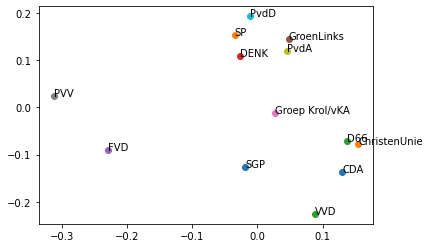

In [105]:
# hide
# More is less the same result is obtained with cosine similarity
from sklearn.metrics.pairwise import cosine_distances
from sklearn.manifold import MDS
cos_distances = cosine_distances(data)
mds_map = MDS(dissimilarity='precomputed')
pos = mds_map.fit_transform(cos_distances)
#pos contains the x and y coordinates of each of the documents
x = pos[:,0]
y = pos[:,1]
#we will need matplotlib to generate a scatter plot
import matplotlib.pyplot as plt
for i, j, name in zip(x,y, [p[5:] for p in stem_column]):
    plt.scatter(i,j)
    plt.text(i,j,name)
plt.show()

# hide
## Kunnen we de stemuitslag voorspellen?

In [69]:
# hide
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

scores = []
for chamber in chambers:
    X = df.loc[df['Kamer'] == chamber][indiener_column + medeindiener_column].dropna(how='all',axis=1)
    X_imp = SimpleImputer(strategy='most_frequent').fit_transform(X)

    y = df.loc[df['Kamer'] == chamber]['BesluitSoort']
    X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.5, shuffle=False)


    clf = LogisticRegression(random_state=0, solver='lbfgs',
                             multi_class='ovr').fit(X_train, y_train)

    print('score',clf.score(X_test, y_test),'baseline',y.value_counts()[0]/len(y))
    scores.append(clf.score(X_test, y_test))
    print (confusion_matrix(y_test, clf.predict(X_test), sample_weight=None))
print (np.mean(scores))

score 0.5340189873417721 baseline 0.5621044303797469
[[675   0]
 [589   0]]
score 0.603781512605042 baseline 0.5941176470588235
[[1437    0]
 [ 943    0]]
score 0.5530133928571429 baseline 0.599386103618268
[[2973    0]
 [2403    0]]
score 0.4161728825374695 baseline 0.4765141612200436
[[2388    0]
 [3350    0]]
0.5267466938353565


In een volgend blog (dat ik hopelijk nog voor de verkiezingen publiceer) gaan we aan de slag met de inhoud van de moties. We clusteren de moties op inhoud en kijken of er trends zijn in onderwerpen en welke partij het meest actief is op bepaalde onderwerpen.

In [ ]:
> Note: Ik heb enkele visualisaties in de blog achterwege gelaten om het nog enigzins leesbaar te houden. Wil je deze ook nog zien, of de code hergebruiken, dan is het jupyter notebook hier beschikbaar